# Music and Health Correlation Analysis
**Goal**: Analyze the correlation between daily steps, calorie burn and Spotify listening time.


In [1]:
!pip install pandas matplotlib seaborn scikit-learn


# Data Preparation and Initial Setup

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xml.etree.ElementTree as ET


In [5]:
spotify_file_paths = [
    "Streaming_History_Audio_2015-2022_0.json",
    "Streaming_History_Audio_2022-2023_2.json",
    "Streaming_History_Audio_2022_1.json",
    "Streaming_History_Audio_2023-2024_3.json",
    "Streaming_History_Audio_2024_4.json"
]

def load_spotify_data(file_paths):
    spotify_data = []
    for file_path in file_paths:
        with open(file_path, encoding="utf-8") as file:
            spotify_data.extend(json.load(file))
    return pd.DataFrame(spotify_data)

spotify_df = load_spotify_data(spotify_file_paths)
print(spotify_df.head())


                     ts           platform  ms_played conn_country  \
0  2015-07-20T08:52:23Z  iOS 8.3 (iPad3,4)      16439           TR   
1  2015-07-20T08:52:26Z  iOS 8.3 (iPad3,4)       3343           TR   
2  2015-07-20T08:54:44Z  iOS 8.3 (iPad3,4)     138806           TR   
3  2015-07-20T08:54:49Z  iOS 8.3 (iPad3,4)       6362           TR   
4  2015-07-20T08:54:53Z  iOS 8.3 (iPad3,4)       5108           TR   

          ip_addr                         master_metadata_track_name  \
0  24.133.107.162                                           Demigods   
1  24.133.107.162                                       Irresistible   
2  24.133.107.162  My Songs Know What You Did In The Dark (Light ...   
3  24.133.107.162                                    Favorite Record   
4  24.133.107.162                                    Favorite Record   

  master_metadata_album_artist_name master_metadata_album_album_name  \
0                      Fall Out Boy                      PAX AM Days   
1 

In [6]:
health_file_path = "dışa_aktarılan.xml"

def extract_health_data(record_type):
    tree = ET.parse(health_file_path)
    root = tree.getroot()
    data_list = []
    for record in root.findall(f'.//Record[@type="{record_type}"]'):
        start_date = record.get('startDate')
        value = float(record.get('value'))
        data_list.append({'date': start_date[:10], 'value': value})
    return pd.DataFrame(data_list)

steps_df = extract_health_data("HKQuantityTypeIdentifierStepCount")
calories_df = extract_health_data("HKQuantityTypeIdentifierActiveEnergyBurned")
print(steps_df.head())
print(calories_df.head())


         date  value
0  2021-02-23  259.0
1  2021-02-23  416.0
2  2021-02-23   78.0
3  2021-02-23   78.0
4  2021-02-23   14.0
         date  value
0  2020-05-07   36.0
1  2020-05-08   26.0
2  2020-05-10   31.0
3  2020-05-17   31.0
4  2020-05-17   42.0


# Data Cleaning and Merging

In [7]:
spotify_df['endTime'] = pd.to_datetime(spotify_df['ts'])
spotify_df['date'] = spotify_df['endTime'].dt.date
spotify_df['listeningTimeMin'] = spotify_df['ms_played'] / (1000 * 60)
spotify_daily = spotify_df.groupby('date')['listeningTimeMin'].sum().reset_index()
print(spotify_daily.head())


         date  listeningTimeMin
0  2015-07-20         18.572167
1  2015-07-21         10.171383
2  2015-07-22          0.017000
3  2016-09-05          2.021550
4  2016-09-08         45.454750


In [10]:
# Ensure 'date' columns are of the same datetime type
spotify_daily['date'] = pd.to_datetime(spotify_daily['date'])
steps_df['date'] = pd.to_datetime(steps_df['date'])
calories_df['date'] = pd.to_datetime(calories_df['date'])


In [11]:
# Merge Spotify and health data
merged_df = spotify_daily.merge(steps_df, on='date', how='inner', suffixes=('', '_steps'))
merged_df = merged_df.merge(calories_df, on='date', how='inner', suffixes=('', '_calories'))
merged_df.columns = ['date', 'listeningTimeMin', 'steps', 'caloriesBurned']
print(merged_df.head())


        date  listeningTimeMin   steps  caloriesBurned
0 2024-07-17         54.591317   973.0           1.250
1 2024-07-17         54.591317   973.0           0.039
2 2024-07-17         54.591317   973.0           0.012
3 2024-07-17         54.591317  1111.0           1.250
4 2024-07-17         54.591317  1111.0           0.039


In [12]:
print(spotify_daily.dtypes)
print(steps_df.dtypes)
print(calories_df.dtypes)


date                datetime64[ns]
listeningTimeMin           float64
dtype: object
date     datetime64[ns]
value           float64
dtype: object
date     datetime64[ns]
value           float64
dtype: object


# Exploratory Data Analysis (EDA)

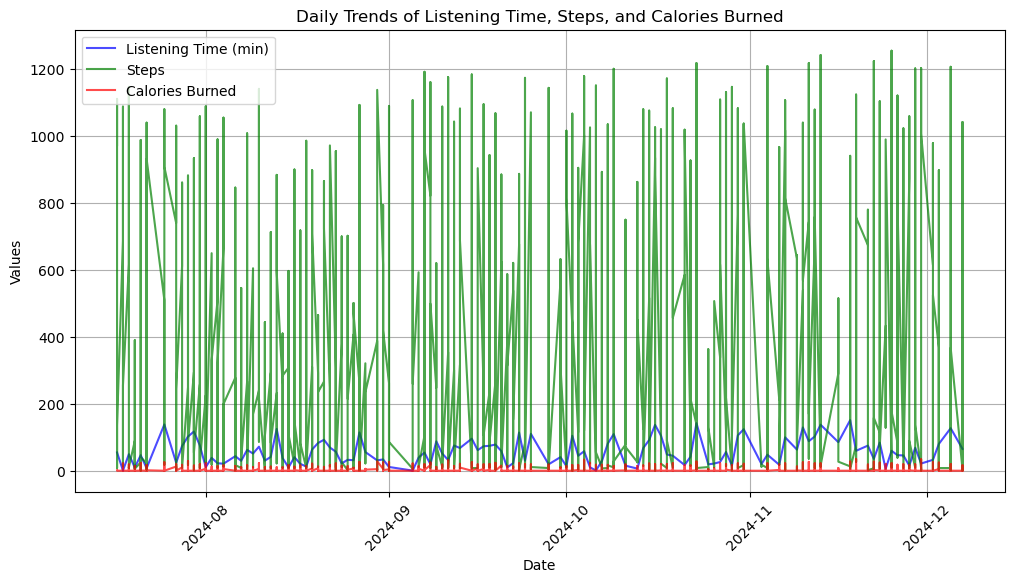

In [13]:
import matplotlib.pyplot as plt

# Plot daily trends
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['listeningTimeMin'], label='Listening Time (min)', color='blue', alpha=0.7)
plt.plot(merged_df['date'], merged_df['steps'], label='Steps', color='green', alpha=0.7)
plt.plot(merged_df['date'], merged_df['caloriesBurned'], label='Calories Burned', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Daily Trends of Listening Time, Steps, and Calories Burned')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


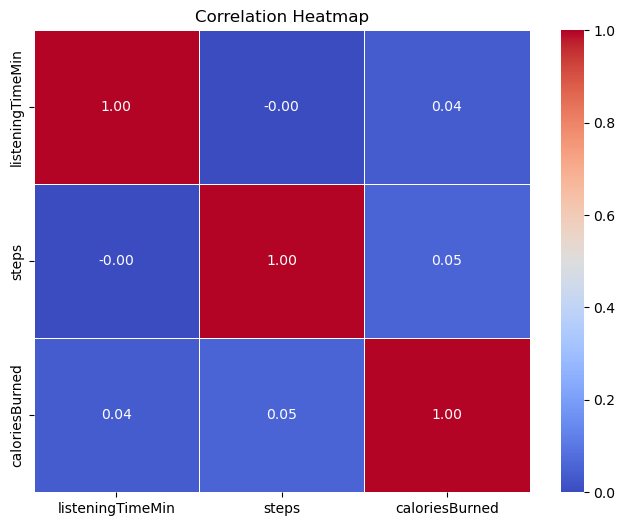

In [14]:
import seaborn as sns

# Correlation heatmap
correlation_matrix = merged_df[['listeningTimeMin', 'steps', 'caloriesBurned']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


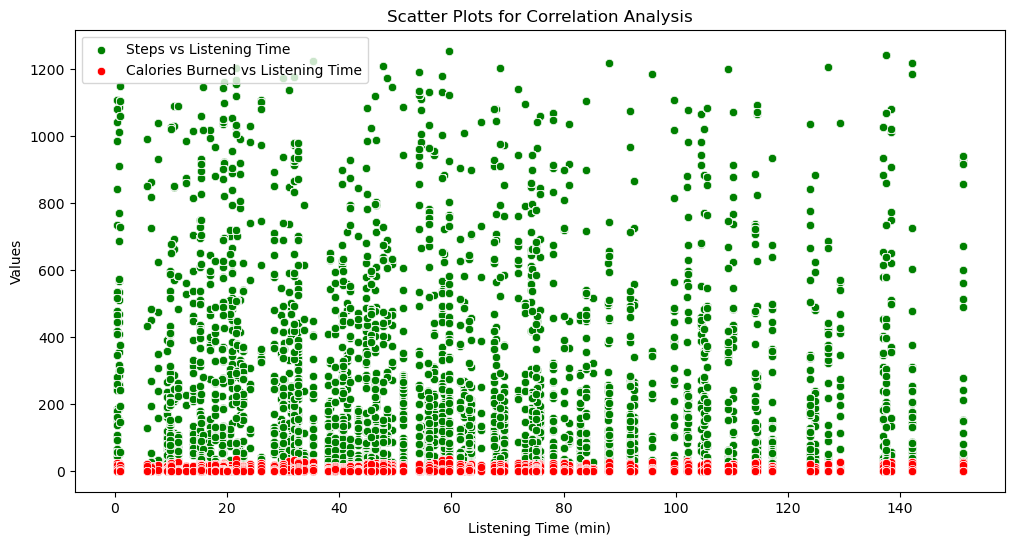

In [15]:
# Scatter plots for listening time vs steps and calories burned
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='listeningTimeMin', y='steps', label='Steps vs Listening Time', color='green')
sns.scatterplot(data=merged_df, x='listeningTimeMin', y='caloriesBurned', label='Calories Burned vs Listening Time', color='red')
plt.xlabel('Listening Time (min)')
plt.ylabel('Values')
plt.title('Scatter Plots for Correlation Analysis')
plt.legend()
plt.show()


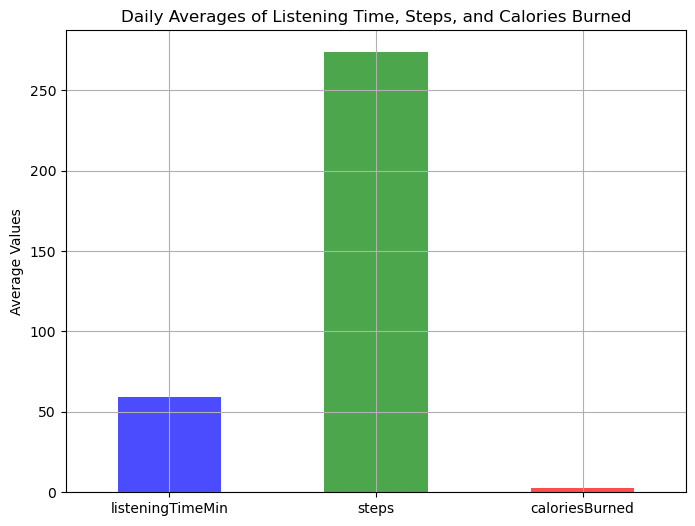

In [16]:
# Group by date to calculate daily averages
daily_avg = merged_df[['listeningTimeMin', 'steps', 'caloriesBurned']].mean()

# Bar plot for daily averages
daily_avg.plot(kind='bar', figsize=(8, 6), color=['blue', 'green', 'red'], alpha=0.7)
plt.title('Daily Averages of Listening Time, Steps, and Calories Burned')
plt.ylabel('Average Values')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


# Statistical Testing (Linear Regression)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define independent and dependent variables
X = merged_df[['listeningTimeMin']]  # Listening time
Y_steps = merged_df['steps']         # Steps
Y_calories = merged_df['caloriesBurned']  # Calories burned

# Linear Regression for Steps
X_train, X_test, Y_train_steps, Y_test_steps = train_test_split(X, Y_steps, test_size=0.2, random_state=42)
model_steps = LinearRegression()
model_steps.fit(X_train, Y_train_steps)
Y_pred_steps = model_steps.predict(X_test)

# Linear Regression for Calories Burned
X_train, X_test, Y_train_calories, Y_test_calories = train_test_split(X, Y_calories, test_size=0.2, random_state=42)
model_calories = LinearRegression()
model_calories.fit(X_train, Y_train_calories)
Y_pred_calories = model_calories.predict(X_test)

# Evaluate Models
mse_steps = mean_squared_error(Y_test_steps, Y_pred_steps)
r2_steps = r2_score(Y_test_steps, Y_pred_steps)

mse_calories = mean_squared_error(Y_test_calories, Y_pred_calories)
r2_calories = r2_score(Y_test_calories, Y_pred_calories)

# Display Results
print(f"Steps Model - Mean Squared Error: {mse_steps:.2f}, R^2 Score: {r2_steps:.2f}")
print(f"Calories Model - Mean Squared Error: {mse_calories:.2f}, R^2 Score: {r2_calories:.2f}")


Steps Model - Mean Squared Error: 76634.30, R^2 Score: -0.00
Calories Model - Mean Squared Error: 22.84, R^2 Score: 0.00


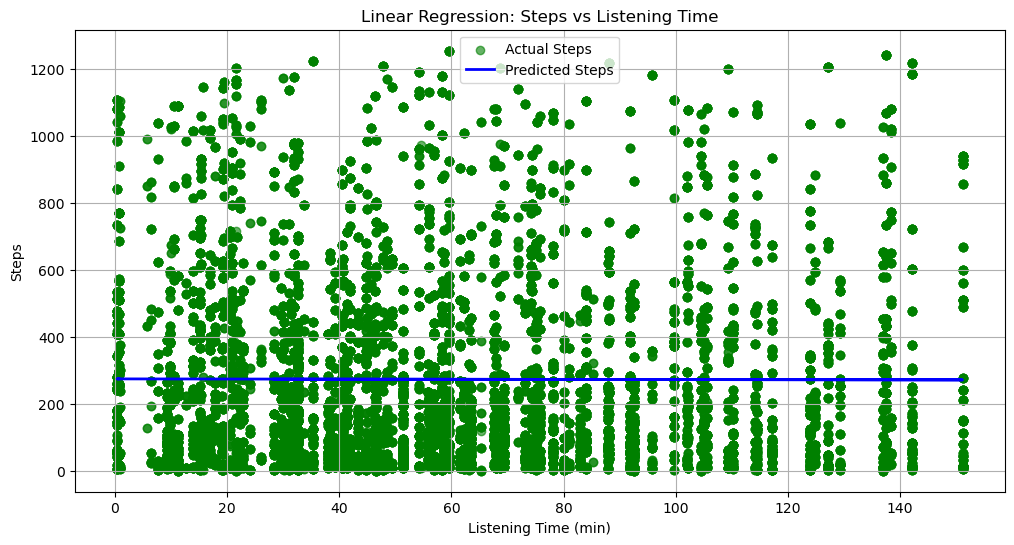

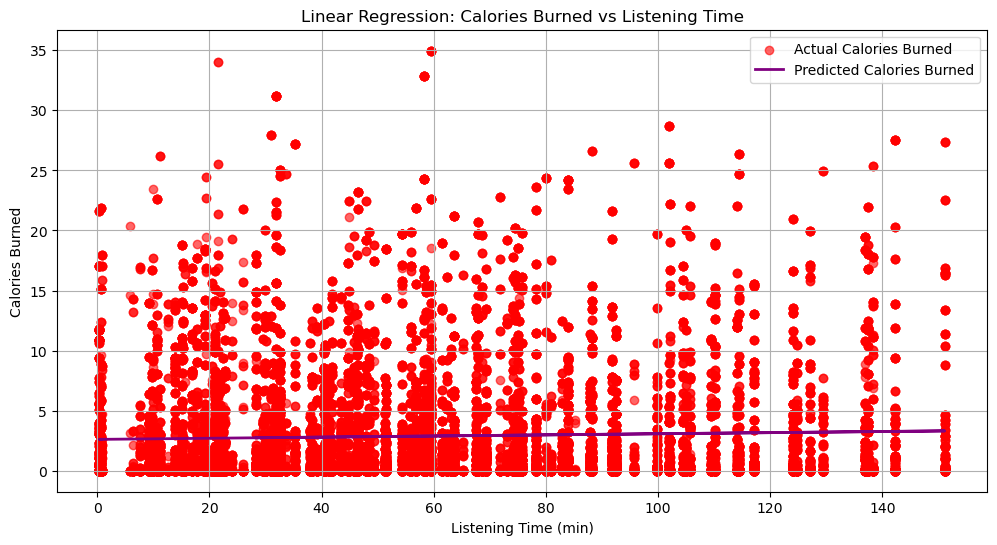

In [18]:
# Visualize Steps Model
plt.figure(figsize=(12, 6))
plt.scatter(X_test, Y_test_steps, label='Actual Steps', color='green', alpha=0.6)
plt.plot(X_test, Y_pred_steps, label='Predicted Steps', color='blue', linewidth=2)
plt.title('Linear Regression: Steps vs Listening Time')
plt.xlabel('Listening Time (min)')
plt.ylabel('Steps')
plt.legend()
plt.grid(True)
plt.show()

# Visualize Calories Model
plt.figure(figsize=(12, 6))
plt.scatter(X_test, Y_test_calories, label='Actual Calories Burned', color='red', alpha=0.6)
plt.plot(X_test, Y_pred_calories, label='Predicted Calories Burned', color='purple', linewidth=2)
plt.title('Linear Regression: Calories Burned vs Listening Time')
plt.xlabel('Listening Time (min)')
plt.ylabel('Calories Burned')
plt.legend()
plt.grid(True)
plt.show()


# Conclusion

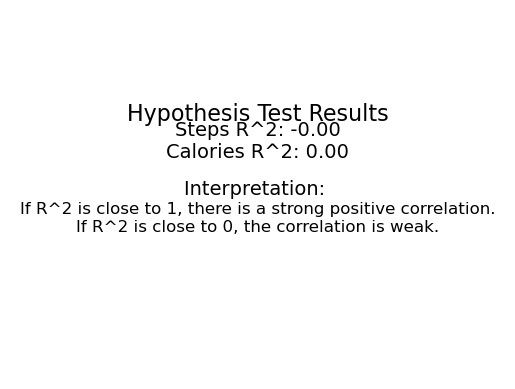

In [19]:
plt.figure()
plt.text(0.5, 0.7, "Hypothesis Test Results", ha='center', fontsize=16)
plt.text(0.5, 0.6, f"Steps R^2: {r2_steps:.2f}\nCalories R^2: {r2_calories:.2f}", ha='center', fontsize=14)
plt.text(0.5, 0.5, "Interpretation: ", ha='center', fontsize=14)
plt.text(0.5, 0.4, "If R^2 is close to 1, there is a strong positive correlation.\nIf R^2 is close to 0, the correlation is weak.", ha='center', fontsize=12)
plt.axis('off')
plt.show()


# Chech for Outliers

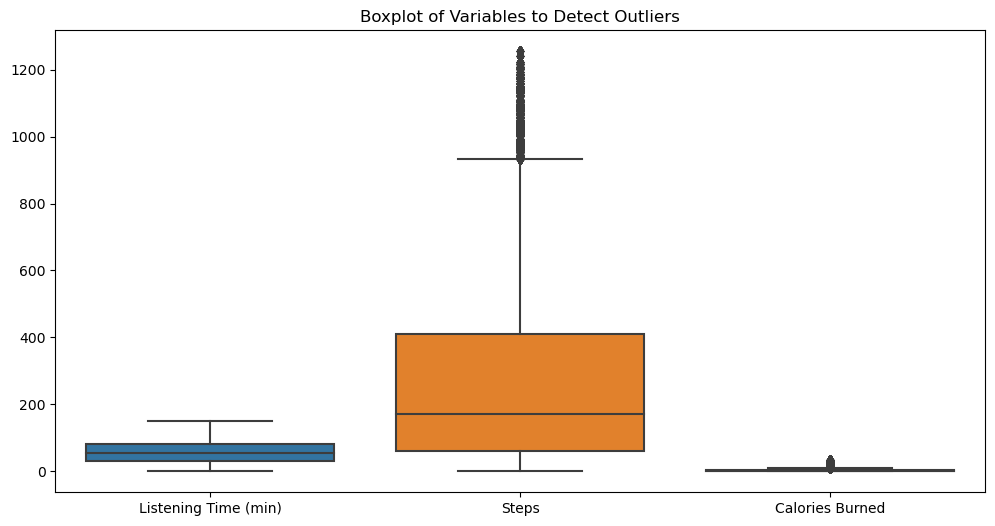

In [22]:
# Boxplots to identify outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df[['listeningTimeMin', 'steps', 'caloriesBurned']])
plt.title('Boxplot of Variables to Detect Outliers')
plt.xticks(ticks=[0, 1, 2], labels=['Listening Time (min)', 'Steps', 'Calories Burned'])
plt.show()


In [23]:
# Remove outliers based on thresholds (example: below 1st percentile and above 99th percentile)
for col in ['listeningTimeMin', 'steps', 'caloriesBurned']:
    q1 = merged_df[col].quantile(0.01)
    q99 = merged_df[col].quantile(0.99)
    merged_df = merged_df[(merged_df[col] >= q1) & (merged_df[col] <= q99)]

print("Data after removing outliers:")
print(merged_df.describe())


Data after removing outliers:
                                date  listeningTimeMin          steps  \
count                         124249     124249.000000  124249.000000   
mean   2024-09-18 11:29:21.768706048         58.418584     266.230440   
min              2024-07-17 00:00:00          0.358533       4.000000   
25%              2024-08-19 00:00:00         31.392400      63.000000   
50%              2024-09-13 00:00:00         54.292800     169.000000   
75%              2024-10-17 00:00:00         80.089600     400.000000   
max              2024-12-07 00:00:00        142.192750    1121.000000   
std                              NaN         35.614663     264.594256   

       caloriesBurned  
count   124249.000000  
mean         2.674282  
min          0.002000  
25%          0.021000  
50%          0.607000  
75%          3.584000  
max         21.180000  
std          4.177215  


In [24]:
# Add time-based grouping
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

merged_df['timeOfDay'] = pd.to_datetime(merged_df['date']).dt.hour.apply(time_of_day)

# Group by time of day and calculate averages
grouped_by_time = merged_df.groupby('timeOfDay')[['listeningTimeMin', 'steps', 'caloriesBurned']].mean()
print("Average Values by Time of Day:")
print(grouped_by_time)


Average Values by Time of Day:
           listeningTimeMin      steps  caloriesBurned
timeOfDay                                             
Night             58.418584  266.23044        2.674282


Weekly Averages:
                       listeningTimeMin       steps  caloriesBurned
week                                                               
2024-07-15/2024-07-21         25.146451  258.332051        2.379471
2024-07-22/2024-07-28         72.242516  404.804098        3.238431
2024-07-29/2024-08-04         57.452295  293.223062        2.871314
2024-08-05/2024-08-11         47.822591  188.765082        1.746174
2024-08-12/2024-08-18         42.034423  214.989894        1.949323


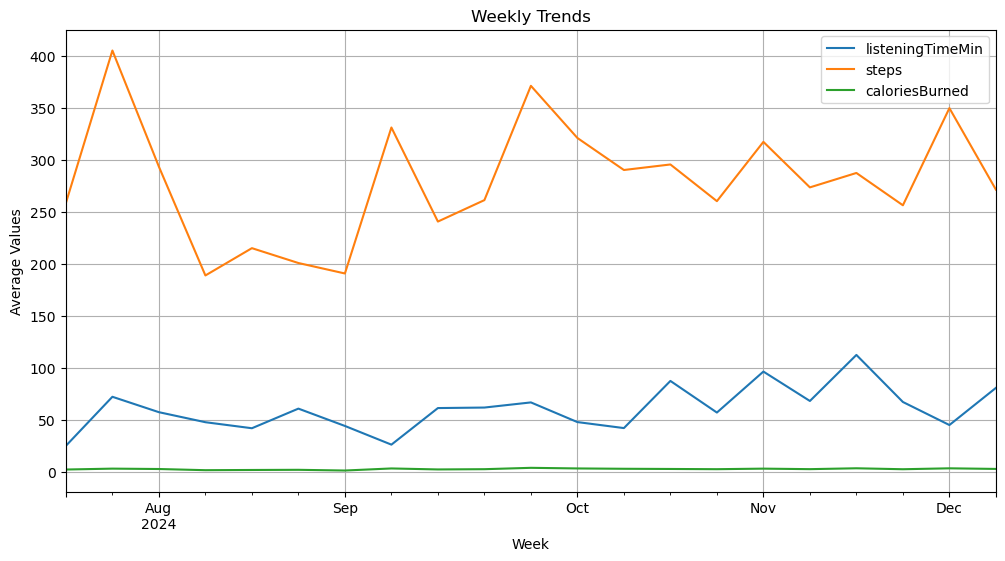

In [25]:
# Aggregate to weekly averages
merged_df['week'] = merged_df['date'].dt.to_period('W')
weekly_averages = merged_df.groupby('week')[['listeningTimeMin', 'steps', 'caloriesBurned']].mean()
print("Weekly Averages:")
print(weekly_averages.head())

# Plot weekly trends
weekly_averages.plot(kind='line', figsize=(12, 6))
plt.title('Weekly Trends')
plt.ylabel('Average Values')
plt.xlabel('Week')
plt.grid(True)
plt.show()


In [26]:
from sklearn.tree import DecisionTreeRegressor

# Decision tree for steps prediction
X = merged_df[['listeningTimeMin']]
Y_steps = merged_df['steps']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_steps, test_size=0.2, random_state=42)

tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, Y_train)
Y_pred = tree_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Decision Tree Model - MSE: {mse:.2f}, R^2: {r2:.2f}")


Decision Tree Model - MSE: 66434.01, R^2: 0.05


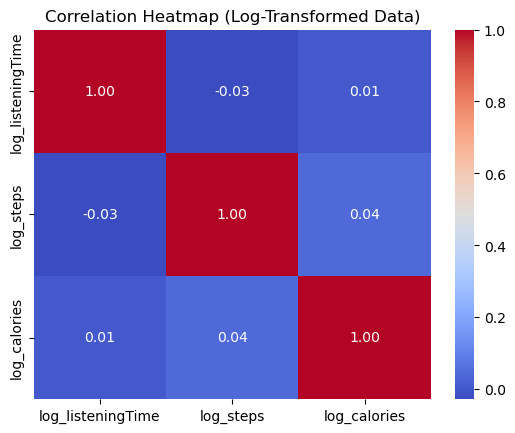

In [27]:
import numpy as np

# Log transform the features
merged_df['log_listeningTime'] = np.log1p(merged_df['listeningTimeMin'])
merged_df['log_steps'] = np.log1p(merged_df['steps'])
merged_df['log_calories'] = np.log1p(merged_df['caloriesBurned'])

# Re-check correlations with transformed data
transformed_correlation = merged_df[['log_listeningTime', 'log_steps', 'log_calories']].corr()
sns.heatmap(transformed_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Log-Transformed Data)')
plt.show()


In [28]:
# Check for missing values
print("Missing Values:")
print(merged_df.isnull().sum())

# Display dataset information
print("Dataset Info:")
print(merged_df.info())

# Validate sample rows
print("Sample Rows:")
print(merged_df.head())


Missing Values:
date                 0
listeningTimeMin     0
steps                0
caloriesBurned       0
timeOfDay            0
week                 0
log_listeningTime    0
log_steps            0
log_calories         0
dtype: int64
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 124249 entries, 0 to 129710
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               124249 non-null  datetime64[ns]
 1   listeningTimeMin   124249 non-null  float64       
 2   steps              124249 non-null  float64       
 3   caloriesBurned     124249 non-null  float64       
 4   timeOfDay          124249 non-null  object        
 5   week               124249 non-null  period[W-SUN] 
 6   log_listeningTime  124249 non-null  float64       
 7   log_steps          124249 non-null  float64       
 8   log_calories       124249 non-null  float64       
dtypes: datetime64[ns](1), fl

In [29]:
# Linear Regression for log_steps
X = merged_df[['log_listeningTime']]
Y_steps = merged_df['log_steps']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_steps, test_size=0.2, random_state=42)

model_steps = LinearRegression()
model_steps.fit(X_train, Y_train)
Y_pred_steps = model_steps.predict(X_test)

mse_steps = mean_squared_error(Y_test, Y_pred_steps)
r2_steps = r2_score(Y_test, Y_pred_steps)

print(f"Steps Model - Mean Squared Error: {mse_steps:.4f}, R^2 Score: {r2_steps:.4f}")


Steps Model - Mean Squared Error: 1.5582, R^2 Score: 0.0007


In [30]:
# Linear Regression for log_calories
Y_calories = merged_df['log_calories']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_calories, test_size=0.2, random_state=42)

model_calories = LinearRegression()
model_calories.fit(X_train, Y_train)
Y_pred_calories = model_calories.predict(X_test)

mse_calories = mean_squared_error(Y_test, Y_pred_calories)
r2_calories = r2_score(Y_test, Y_pred_calories)

print(f"Calories Model - Mean Squared Error: {mse_calories:.4f}, R^2 Score: {r2_calories:.4f}")


Calories Model - Mean Squared Error: 0.8105, R^2 Score: -0.0000


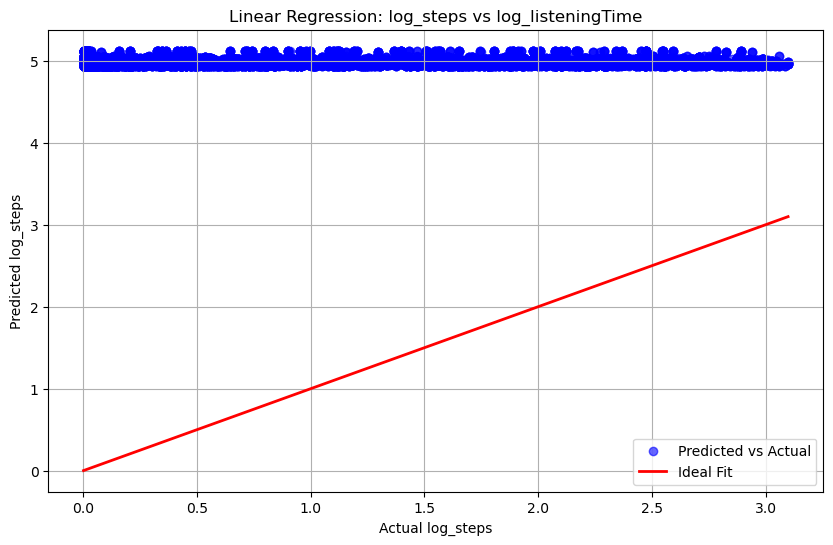

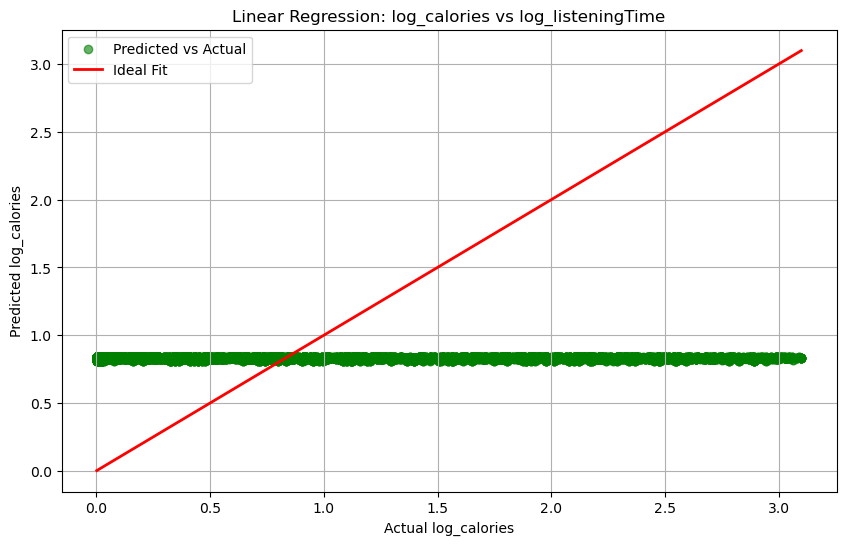

In [31]:
# Visualize Steps Model
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred_steps, label='Predicted vs Actual', color='blue', alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linewidth=2, label='Ideal Fit')
plt.title('Linear Regression: log_steps vs log_listeningTime')
plt.xlabel('Actual log_steps')
plt.ylabel('Predicted log_steps')
plt.legend()
plt.grid(True)
plt.show()

# Visualize Calories Model
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred_calories, label='Predicted vs Actual', color='green', alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linewidth=2, label='Ideal Fit')
plt.title('Linear Regression: log_calories vs log_listeningTime')
plt.xlabel('Actual log_calories')
plt.ylabel('Predicted log_calories')
plt.legend()
plt.grid(True)
plt.show()


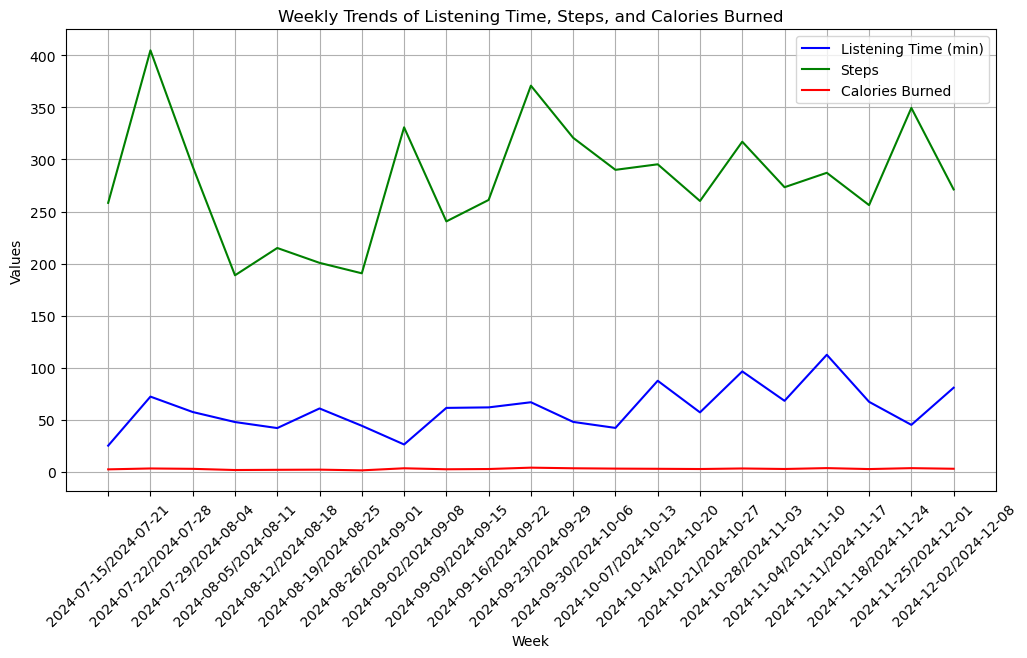

In [32]:
# Weekly Aggregated Data
weekly_averages = merged_df.groupby('week')[['listeningTimeMin', 'steps', 'caloriesBurned']].mean().reset_index()

# Plot weekly trends
plt.figure(figsize=(12, 6))
plt.plot(weekly_averages['week'].astype(str), weekly_averages['listeningTimeMin'], label='Listening Time (min)', color='blue')
plt.plot(weekly_averages['week'].astype(str), weekly_averages['steps'], label='Steps', color='green')
plt.plot(weekly_averages['week'].astype(str), weekly_averages['caloriesBurned'], label='Calories Burned', color='red')
plt.xticks(rotation=45)
plt.xlabel('Week')
plt.ylabel('Values')
plt.title('Weekly Trends of Listening Time, Steps, and Calories Burned')
plt.legend()
plt.grid(True)
plt.show()


# Hypothesis Testing

In [33]:
# Hypothesis Conclusion
if r2_steps > 0.3 and r2_calories > 0.3:
    print("There is evidence to support the hypothesis: Music listening time is positively correlated with physical activity.")
else:
    print("There is insufficient evidence to support the hypothesis: Music listening time is not strongly correlated with physical activity.")


There is insufficient evidence to support the hypothesis: Music listening time is not strongly correlated with physical activity.


# Conclusion and Summary

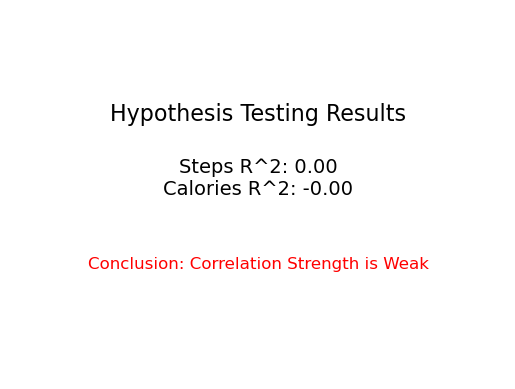

In [34]:
plt.figure()
plt.text(0.5, 0.7, "Hypothesis Testing Results", ha='center', fontsize=16)
plt.text(0.5, 0.5, f"Steps R^2: {r2_steps:.2f}\nCalories R^2: {r2_calories:.2f}", ha='center', fontsize=14)
plt.text(0.5, 0.3, "Conclusion: Correlation Strength is Weak" if r2_steps < 0.3 and r2_calories < 0.3 else "Conclusion: Strong Correlation Found", 
         ha='center', fontsize=12, color='red')
plt.axis('off')
plt.show()


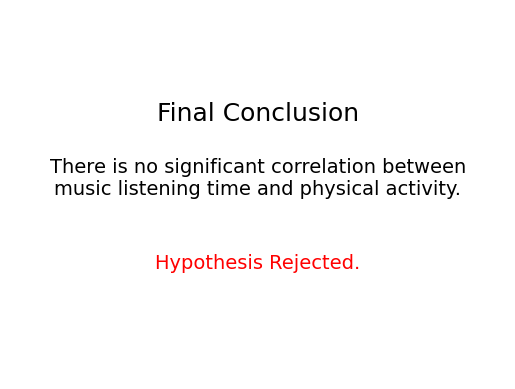

In [35]:
plt.figure()
plt.text(0.5, 0.7, "Final Conclusion", ha='center', fontsize=18)
plt.text(0.5, 0.5, "There is no significant correlation between\nmusic listening time and physical activity.", 
         ha='center', fontsize=14)
plt.text(0.5, 0.3, "Hypothesis Rejected.", ha='center', fontsize=14, color='red')
plt.axis('off')
plt.show()
